# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfall in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [1]:
!nvidia-smi

Wed Mar 20 04:33:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
# For summarizing and visualizing models
!pip install torchinfo
!pip install torchviz

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [23]:
!pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [24]:
from kaggle_secrets import UserSecretsClient

!wandb login {UserSecretsClient().get_secret("wandb_api_key")}

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.__version__ # 1.10.0+cu111

'2.1.2'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [26]:
def read_data(months, data_dir='/kaggle/input/pattern-recog/dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [27]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [28]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:**

- for X data (features)
we flatten each datapoint into 1x75 vector and feed to train without order considering

- for Y data (label)
flatten all label because we doesn't care about order.

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [29]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)
        self.x = self.normalizer.transform(x) # Normalize

    def __getitem__(self, index):
        x = self.x[index].reshape(1,-1) # Retrieve data
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [30]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [31]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [32]:
train_loader_ff = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_ff = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_ff = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [33]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:** because our target label isn't class or category and we would like to minimize the different between our prediction and actual labels

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [35]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:** Last activation function is linear because our y can be real number.

ReLU is more suitable in this case because the precipitation can't be negative for sure.

In [36]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

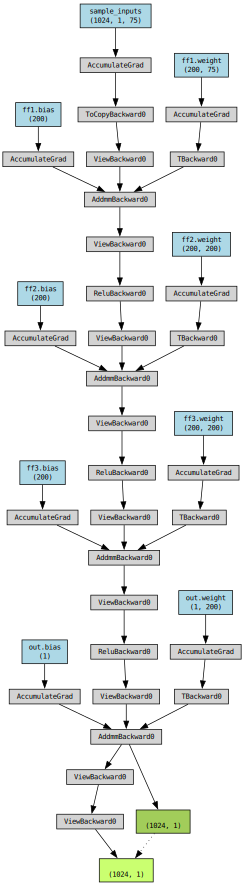

In [37]:
from torchviz import make_dot
# Visualize model with torchviz
sample_inputs = next(iter(train_loader_ff))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [38]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:** because input has 75 features and output of first layer has 200 units so total parameters is 75*200 + 200 = 15,200 parameters

# Training

In [39]:
def train_model(model,
                optimizer,
                scheduler,
                loss_fn,
                train_loader,
                val_loader,
                device,
                model_name,
                config):
    global wandb

    train_losses = []
    val_losses = []
    learning_rates = []

    # Start wandb run
    wandb.init(
    project='precipitation-nowcasting',
    config=config,
    )

    # Log parameters and gradients
    wandb.watch(model, log='all')

    for epoch in range(config['epochs']):  # loop over the dataset multiple times

        # Training
        train_loss = []
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Flag model as training. Some layers behave differently in training and
        # inference modes, such as dropout, BN, etc.
        model.train()

        print(f"Training epoch {epoch+1}...")
        print(f"Current LR: {current_lr}")

        for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Reset the gradient
            optimizer.zero_grad()

            # Predict
            y_pred = model(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Compute gradient
            loss.backward()

            # Update parameters
            optimizer.step()

            # Log stuff
            train_loss.append(loss)

        avg_train_loss = torch.stack(train_loss).mean().item()
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        with torch.no_grad(): # No gradient is required during validation
            print(f"Validating epoch {epoch+1}")
            val_loss = []
            for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
                # Transfer data from cpu to gpu
                inputs = inputs.to(device)
                y_true = y_true.to(device)

                # Predict
                y_pred = model(inputs)

                # Calculate loss
                loss = loss_fn(y_pred, y_true)

                # Log stuff
                val_loss.append(loss)

            avg_val_loss = torch.stack(val_loss).mean().item()
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

            # LR adjustment with scheduler
            scheduler.step(avg_val_loss)

            # Save checkpoint if val_loss is the best we got
            best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
            if avg_val_loss < best_val_loss:
                # Save whatever you want
                state = {
                    'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'best_val_loss': best_val_loss,
                }

                print(f"Saving new best model..")
                torch.save(state, f'{model_name}.pth.tar')

        wandb.log({
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'lr': current_lr,
        })

    wandb.unwatch()
    wandb.finish()
    print('Finished Training')

    return train_losses, val_losses, learning_rates, model

In [40]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

train_losses, val_losses, learning_rates, model_ff = train_model(model=model_ff,
                                                                 optimizer=optimizer,
                                                                 scheduler=scheduler,
                                                                 loss_fn=loss_fn,
                                                                 train_loader=train_loader_ff,
                                                                 val_loader=val_loader_ff,
                                                                 device=device,
                                                                 model_name='model_ff',
                                                                 config=config)

Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9348
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6606
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9231
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6586
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9227
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6587
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9209
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6592
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9206
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6607
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9201
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6579
Saving new best model..
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9193
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6577
Saving new best model..
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9192
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6593
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9192
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6584
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9192
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6578


lr,█████▁▁▁▁▁
train_loss,█▃▃▂▂▁▁▁▁▁
val_loss,█▃▃▄█▁▁▅▂▁
lr,0.002
train_loss,1.91922
val_loss,1.65778


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

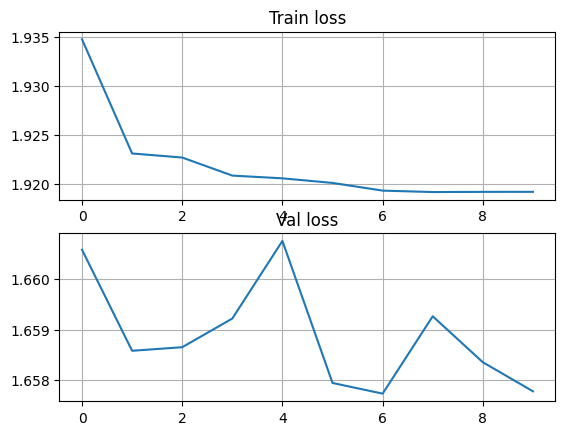

In [41]:
plt.subplot(2,1,1)
plt.title('Train loss')
plt.plot(train_losses, label='train loss')
plt.grid()

plt.subplot(2,1,2)
plt.title('Val loss')
plt.plot(val_losses, label='val loss')
plt.grid()

### TODO#6

When does the model start to overfit?

**Ans:** epoch 6. because a val loss is increased in epoch 7 and afterward

### TODO#7

Plot the learning rate as a function of the epochs.

Text(0.5, 1.0, 'learning rate by epoch')

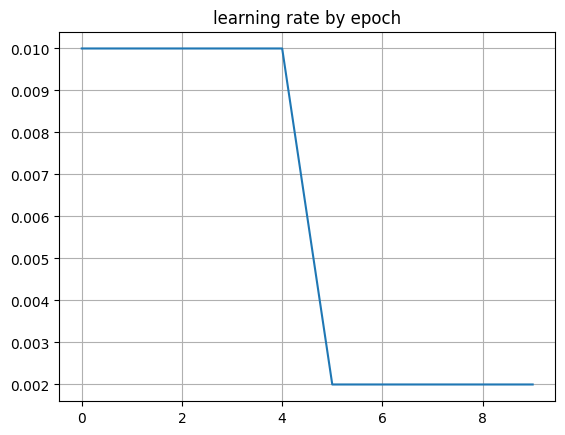

In [42]:
plt.plot(learning_rates)
plt.grid()
plt.title('learning rate by epoch')

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** train loss is not drop for 2 epoch where on epoch 5

# Load Model

Use the code snippet below to load the model you just trained

In [43]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 6 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [44]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
        pass

    def step(self, epoch):
        epoch += 1
        # Changes the learning rate here
        if 0<=epoch<3:
            new_lr = 0.0001+epoch*0.0003
        elif 3<=epoch<6:
            new_lr = 0.0010-(epoch-3)*(0.0005/3)
        elif epoch==6:
            new_lr = 0.0005
        elif epoch==7:
            new_lr = 0.0010
        else:
            new_lr = 0.0010-(epoch-7)*(0.00045)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

In [45]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward_with_myScheduler',
    'lr': 0.0001,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = MyScheduler(optimizer)

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
project='precipitation-nowcasting',
config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_ff)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_ff)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_myScheduler.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })


wandb.unwatch()
wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9192
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6570
Saving new best model..
Training epoch 2...
Current LR: 0.00039999999999999996


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9192
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6558
Saving new best model..
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9183
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6567
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9187
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6569
Training epoch 5...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9179
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6567
Training epoch 6...
Current LR: 0.0006666666666666668


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9181
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6567
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9180
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6561
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9182
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6562
Training epoch 9...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9177
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6557
Saving new best model..
Training epoch 10...
Current LR: 0.00010000000000000005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9170
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6558


lr,▁▃▆█▇▅▄█▄▁
train_loss,██▅▆▄▄▄▅▃▁
val_loss,█▂▇█▆▇▃▄▁▁
lr,0.0001
train_loss,1.91699
val_loss,1.65576


Finished Training


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:**

# Evaluation

In [46]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    model_ff.eval()
    val_loss = []
    with torch.no_grad():
        for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model(inputs)

            # Calculate loss
            loss = nn.MSELoss()(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

    avg_val_loss = torch.stack(val_loss).mean()

    return avg_val_loss

In [47]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [48]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [49]:
print('FF-model')
print('train', evaluate(train_loader_ff, model_ff).item())
print('validate', evaluate(val_loader_ff, model_ff).item())

FF-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9168843030929565


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6557613611221313


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [50]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardWithDropOutNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardWithDropOutNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.dropout(y)
        y = self.out(y)
        return y.reshape(-1, 1)

In [51]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward_with_dropout',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff_do = FeedForwardWithDropOutNN(hidden_size=config['hidden_size'])
model_ff_do = model_ff_do.to(device)
optimizer = torch.optim.Adam(model_ff_do.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

train_losses, val_losses, learning_rates, model_ff_do = train_model(model=model_ff_do,
                                                                    optimizer=optimizer,
                                                                    scheduler=scheduler,
                                                                    loss_fn=loss_fn,
                                                                    train_loader=train_loader_ff,
                                                                    val_loader=val_loader_ff,
                                                                    device=device,
                                                                    model_name='model_ff_do',
                                                                    config=config)

start training ff dropout


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9255
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6581
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9206
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6615
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9213
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6603
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9230
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6605
Training epoch 5...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9232
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6611
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9222
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6593
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9204
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6590
Training epoch 8...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9203
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6586
Training epoch 9...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9201
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6585
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9200
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6582


lr,████▂▂▂▁▁▁
train_loss,█▂▃▅▅▄▁▁▁▁
val_loss,▁█▅▆▇▃▃▂▂▁
lr,0.0004
train_loss,1.92004
val_loss,1.65818


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

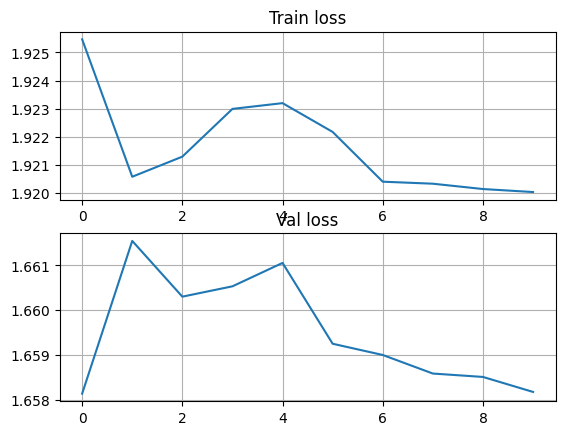

In [52]:
# Plot here
plt.subplot(2,1,1)
plt.title('Train loss')
plt.plot(train_losses, label='train loss')
plt.grid()

plt.subplot(2,1,2)
plt.title('Val loss')
plt.plot(val_losses, label='val loss')
plt.grid()

In [53]:
# Evaluate
print('FF-model with dropout')
print('train', evaluate(train_loader_ff, model_ff_do).item())
print('validate', evaluate(val_loader_ff, model_ff_do).item())

FF-model with dropout


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9198009967803955


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6581772565841675


# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [54]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class RainfallDatasetCNN(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_cnn(x_train, y_train, x_val, y_val):
    x_train_cnn = x_train.reshape((-1, 3, 5, 5))
    y_train_cnn = y_train.reshape((-1, 1))
    x_val_cnn = x_val.reshape((-1, 3, 5, 5))
    y_val_cnn = y_val.reshape((-1, 1))
    x_test_cnn = x_test.reshape((-1, 3, 5, 5))
    y_test_cnn = y_test.reshape((-1, 1))

    return x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn

x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn = preprocess_for_cnn(x_train, y_train, x_val, y_val)
print(x_train_cnn.shape, y_train_cnn.shape)
print(x_val_cnn.shape, y_val_cnn.shape)
print(x_test_cnn.shape, y_test_cnn.shape)

train_dataset = RainfallDatasetCNN(x_train_cnn, y_train_cnn)
val_dataset = RainfallDatasetCNN(x_val_cnn, y_val_cnn)
test_dataset = RainfallDatasetCNN(x_test_cnn, y_test_cnn)

train_loader_cnn = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_cnn = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_cnn = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 3, 5, 5) (1147740, 1)
(464195, 3, 5, 5) (464195, 1)
(558575, 3, 5, 5) (558575, 1)
(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [55]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv = nn.Conv2d(3, 200, 3)
        self.linear1 = nn.Linear(1800, 200)
        self.linear2 = nn.Linear(200, 200)
        self.out = nn.Linear(200, 1)

    def forward(self, x):
        x = self.conv(x)
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.out(x)
        return x

summary(CNN_model(), input_size=next(iter(train_loader_cnn))[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_model                                [1024, 1]                 --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
Total mult-adds (M): 461.83
Input size (MB): 0.31
Forward/backward pass size (MB): 18.03
Params size (MB): 1.62
Estimated Total Size (MB): 19.96

In [56]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'CNN',
    'lr': 0.005,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_cnn = CNN_model()
model_cnn = model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

train_losses, val_losses, learning_rates, model_cnn = train_model(model=model_cnn,
                                                                    optimizer=optimizer,
                                                                    scheduler=scheduler,
                                                                    loss_fn=loss_fn,
                                                                    train_loader=train_loader_cnn,
                                                                    val_loader=val_loader_cnn,
                                                                    device=device,
                                                                    model_name='CNN_model',
                                                                    config=config)

start training conv2d


Training epoch 1...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 64412.8633
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.7134
Saving new best model..
Training epoch 2...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9577
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6945
Saving new best model..
Training epoch 3...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9445
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6762
Saving new best model..
Training epoch 4...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9357
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6690
Saving new best model..
Training epoch 5...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9408
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6617
Saving new best model..
Training epoch 6...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9673
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.8825
Training epoch 7...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 2.1992
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6707
Training epoch 8...
Current LR: 0.005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 2.3798
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6667
Training epoch 9...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9308
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6608
Saving new best model..
Training epoch 10...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9424
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6798


lr,████████▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▃▂▁▁▁█▁▁▁▂
lr,0.001
train_loss,1.94243
val_loss,1.67981


Finished Training


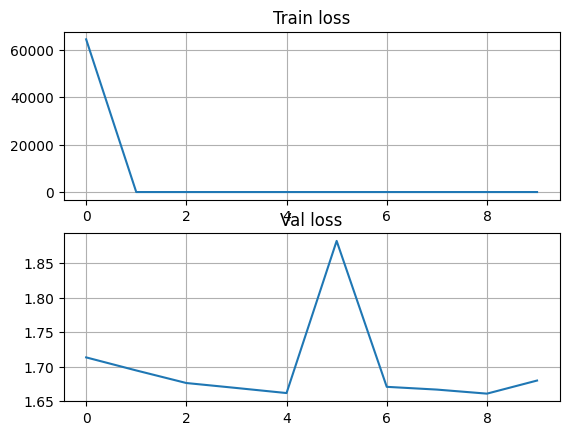

In [57]:
# Plot here
plt.subplot(2,1,1)
plt.title('Train loss')
plt.plot(train_losses, label='train loss')
plt.grid()

plt.subplot(2,1,2)
plt.title('Val loss')
plt.plot(val_losses, label='val loss')
plt.grid()

In [58]:
# Evaluate
print('CNN model')
print('train', evaluate(train_loader_cnn, model_cnn).item())
print('validate', evaluate(val_loader_cnn, model_cnn).item())

CNN model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9357057809829712


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.679810881614685


# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [59]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_gru(x_train, y_train, x_val, y_val):
    x_train_gru = x_train.reshape((-1, 5, 75))
    y_train_gru = y_train.reshape((-1, 5))
    x_val_gru = x_val.reshape((-1, 5, 75))
    y_val_gru = y_val.reshape((-1, 5))
    x_test_gru = x_test.reshape((-1, 5, 75))
    y_test_gru = y_test.reshape((-1, 5))

    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val)
print(x_train_gru.shape, y_train_gru.shape)
print(x_val_gru.shape, y_val_gru.shape)
print(x_test_gru.shape, y_test_gru.shape)

train_dataset = RainfallDatasetGRU(x_train_gru, y_train_gru)
val_dataset = RainfallDatasetGRU(x_val_gru, y_val_gru)
test_dataset = RainfallDatasetGRU(x_test_gru, y_test_gru)

train_loader_gru = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_gru = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_gru = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 75) (229548, 5)
(92839, 5, 75) (92839, 5)
(111715, 5, 75) (111715, 5)
(229548, 5, 75)
(229548, 5)
(92839, 5, 75)
(92839, 5)
(111715, 5, 75)
(111715, 5)


In [60]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class GRU_model(nn.Module):
    def __init__(self):
        super(GRU_model, self).__init__()
        self.gru = nn.GRU(75, 200, 1)
        self.linear1 = nn.Linear(200, 200)
        self.linear2 = nn.Linear(200, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear1(x)
        x = self.linear2(x)

        return x

summary(GRU_model(), input_size=(1024, 5, 75))

Layer (type:depth-idx)                   Output Shape              Param #
GRU_model                                [1024, 5, 1]              --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
Total mult-adds (M): 892.31
Input size (MB): 1.54
Forward/backward pass size (MB): 16.42
Params size (MB): 0.83
Estimated Total Size (MB): 18.79

In [61]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'GRU',
    'lr': 0.005,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_gru = GRU_model()
model_gru = model_gru.to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
project='precipitation-nowcasting',
config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_gru.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_gru)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_gru(inputs).reshape(-1, 5)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_gru.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_gru)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_gru(inputs).reshape(-1, 5)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_gru.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_gru.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })


wandb.unwatch()
wandb.finish()
print('Finished Training')

start training gru


Training epoch 1...
Current LR: 0.005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 2.0615
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6765
Saving new best model..
Training epoch 2...
Current LR: 0.005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9244
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6811
Training epoch 3...
Current LR: 0.005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9176
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6763
Saving new best model..
Training epoch 4...
Current LR: 0.005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9335
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6770
Training epoch 5...
Current LR: 0.001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9173
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6770
Training epoch 6...
Current LR: 0.001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9236
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6791
Training epoch 7...
Current LR: 0.001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9300
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6775
Training epoch 8...
Current LR: 0.0002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9195
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6772
Training epoch 9...
Current LR: 0.0002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9211
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6769
Training epoch 10...
Current LR: 0.0002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9208
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6774


lr,████▂▂▂▁▁▁
train_loss,█▁▁▂▁▁▂▁▁▁
val_loss,▁█▁▂▂▅▃▂▂▃
lr,0.0002
train_loss,1.92081
val_loss,1.67745


Finished Training


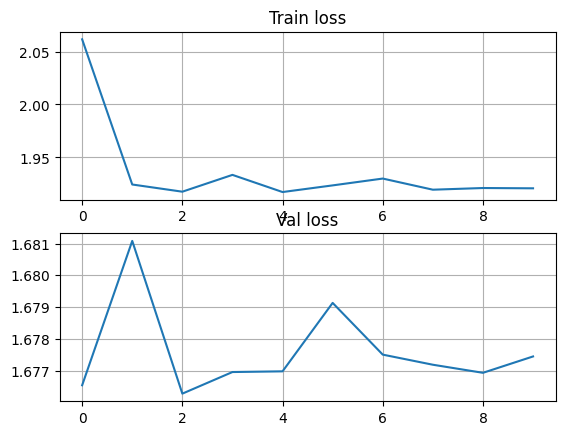

In [62]:
# Plot here
plt.subplot(2,1,1)
plt.title('Train loss')
plt.plot(train_losses, label='train loss')
plt.grid()

plt.subplot(2,1,2)
plt.title('Val loss')
plt.plot(val_losses, label='val loss')
plt.grid()

In [63]:
# Evaluate
# write code here
def gru_evaluate(data_loader, model):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model(inputs).reshape(-1, 5)

            # Calculate loss
            loss = nn.MSELoss()(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

    avg_val_loss = torch.stack(val_loss).mean()

    return avg_val_loss
print('GRU model')
print('train', gru_evaluate(train_loader_gru, model_gru).item())
print('validate', gru_evaluate(val_loader_gru, model_gru).item())

GRU model


  0%|          | 0/225 [00:00<?, ?it/s]

train 1.9188741445541382


  0%|          | 0/91 [00:00<?, ?it/s]

validate 1.6774452924728394


# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [64]:
# Prep data as you see fit
class RainfallDatasetSelf(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_self(x_train, y_train, x_val, y_val):
    x_train_self = x_train.reshape((-1, 3, 5, 5))
    y_train_self = y_train.reshape((-1, 1))
    x_val_self = x_val.reshape((-1, 3, 5, 5))
    y_val_self = y_val.reshape((-1, 1))
    x_test_self = x_test.reshape((-1, 3, 5, 5))
    y_test_self = y_test.reshape((-1, 1))

    return x_train_self, y_train_self, x_val_self, y_val_self, x_test_self, y_test_self

x_train_self, y_train_self, x_val_self, y_val_self, x_test_self, y_test_self = preprocess_for_self(x_train, y_train, x_val, y_val)
print(x_train_self.shape, y_train_self.shape)
print(x_val_self.shape, y_val_self.shape)
print(x_test_self.shape, y_test_self.shape)

train_dataset = RainfallDatasetSelf(x_train_self, y_train_self)
val_dataset = RainfallDatasetSelf(x_val_self, y_val_self)
test_dataset = RainfallDatasetSelf(x_test_self, y_test_self)

train_loader_self = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_self = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_self = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 3, 5, 5) (1147740, 1)
(464195, 3, 5, 5) (464195, 1)
(558575, 3, 5, 5) (558575, 1)
(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [79]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class Self_model(nn.Module):
    def __init__(self):
        super(Self_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, 3, padding='same')
        self.conv2 = nn.Conv2d(200, 200, 3)
        self.linear1 = nn.Linear(200*3**2, 200)
        self.linear2 = nn.Linear(200, 200)
        self.linear3 = nn.Linear(200, 200)
        self.out = nn.Linear(200, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = nn.Flatten()(x)
        x = nn.ReLU()(self.linear1(x))
        x = nn.ReLU()(self.linear2(x))
        x = nn.ReLU()(self.linear3(x))
        x = self.out(x)
        return x

summary(Self_model(), input_size=next(iter(train_loader_self))[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
Self_model                               [1024, 1]                 --
├─Conv2d: 1-1                            [1024, 200, 5, 5]         5,600
├─Conv2d: 1-2                            [1024, 200, 3, 3]         360,200
├─Linear: 1-3                            [1024, 200]               360,200
├─Linear: 1-4                            [1024, 200]               40,200
├─Linear: 1-5                            [1024, 200]               40,200
├─Linear: 1-6                            [1024, 1]                 201
Total params: 806,601
Trainable params: 806,601
Non-trainable params: 0
Total mult-adds (G): 3.91
Input size (MB): 0.31
Forward/backward pass size (MB): 60.63
Params size (MB): 3.23
Estimated Total Size (MB): 64.16

In [83]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'Self',
    'lr': 0.01,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 15
}

# Model
model_self = Self_model()
model_self = model_self.to(device)
optimizer = torch.optim.Adam(model_self.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

train_losses, val_losses, learning_rates, model_self = train_model(model=model_self,
                                                                    optimizer=optimizer,
                                                                    scheduler=scheduler,
                                                                    loss_fn=loss_fn,
                                                                    train_loader=train_loader_self,
                                                                    val_loader=val_loader_self,
                                                                    device=device,
                                                                    model_name='My model',
                                                                    config=config)

start training the best model


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 491222.9375
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 2.1852
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 4.2193
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.7494
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 5.1685
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6769
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9726
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.7611
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 2.1470
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.9505
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 2.2368
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.9068
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9372
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6632
Saving new best model..
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9484
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6745
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9916
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6750
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 2.0446
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6633
Training epoch 11...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 11 train loss: 1.9347
Validating epoch 11


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 11 val loss: 1.6716
Training epoch 12...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 12 train loss: 1.9491
Validating epoch 12


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 12 val loss: 1.6648
Training epoch 13...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 13 train loss: 1.9561
Validating epoch 13


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 13 val loss: 1.7353
Training epoch 14...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 14 train loss: 1.9310
Validating epoch 14


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 14 val loss: 1.6770
Training epoch 15...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 15 train loss: 1.9344
Validating epoch 15


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 15 val loss: 1.6736


lr,██████▂▂▂▂▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▅▄▁▁▁▁▁▁▂▁▁
lr,0.0001
train_loss,1.93439
val_loss,1.67358


Finished Training


In [84]:
# Evaluate best model on validation and test set
print('Self model')
print('train', evaluate(train_loader_self, model_cnn).item())
print('validate', evaluate(val_loader_self, model_cnn).item())

Self model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.935584306716919


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.679810881614685


In [86]:
# Also evaluate your fully-connected model and CNN/GRU/Transformer model on the test set.
print('fully', evaluate(test_loader_ff, model_ff).item())
print('gru', gru_evaluate(test_loader_gru, model_gru).item())
print('cnn', evaluate(test_loader_cnn, model_cnn).item())
print('my model', evaluate(test_loader_self, model_self).item())

  0%|          | 0/546 [00:00<?, ?it/s]

fully 1.1609164476394653


  0%|          | 0/110 [00:00<?, ?it/s]

gru 1.1582012176513672


  0%|          | 0/546 [00:00<?, ?it/s]

cnn 1.1901580095291138


  0%|          | 0/546 [00:00<?, ?it/s]

my model 1.1689870357513428


To get full credit for this part, your best model should be better than the previous models on the **test set**.

### TODO#22

Explain what helped and what did not help here

**Ans:** use ReLU activation function after each linear layer is helped. but add too mmuch layer from CNN give worst perfomance.